In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/cifar-10-python.tar.gz


In [2]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD
import keras
from keras import layers
import matplotlib.pyplot as plt
import sys
import numpy as np
from keras.preprocessing import image

print(os.listdir("../input"))

Using TensorFlow backend.


['cifar-10-python.tar.gz']


In [3]:
from os import listdir, makedirs
from os.path import join, exists, expanduser

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
datasets_dir = join(cache_dir, 'datasets') # /cifar-10-batches-py
if not exists(datasets_dir):
    makedirs(datasets_dir)


!cp ../input/cifar-10-python.tar.gz ~/.keras/datasets/
!ln -s  ~/.keras/datasets/cifar-10-python.tar.gz ~/.keras/datasets/cifar-10-batches-py.tar.gz
!tar xzvf ~/.keras/datasets/cifar-10-python.tar.gz -C ~/.keras/datasets/

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select a single class images (birds)
X_train = X_train[y_train.flatten() == 2]

In [7]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100

In [8]:
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 입력을 16 × 16 크기의 128개 채널을 가진 특성 맵으로 변환합니다
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# 합성곱 층을 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기로 업샘플링합니다
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기의 1개 채널을 가진 특성 맵을 생성합니다
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [9]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 드롭아웃 층을 넣는 것이 아주 중요합니다!
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

In [10]:
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

In [11]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [12]:
# 데이터를 정규화합니다
X_train = X_train.reshape(
    (X_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = join(datasets_dir, 'gan_images')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [13]:

start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 디코딩합니다
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지와 연결합니다
    stop = start + batch_size
    real_images = X_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
    labels += 0.05 * np.random.random(labels.shape)

    # discriminator를 훈련합니다
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 만듭니다
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(X_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그립니다
    if step % 100 == 0:
        # 모델 가중치를 저장합니다
        gan.save_weights('gan.h5')

        # 측정 지표를 출력합니다
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        # 생성된 이미지 하나를 저장합니다
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 비교를 위해 진짜 이미지 하나를 저장합니다
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


스텝 0에서 판별자 손실: 0.7009579
스텝 0에서 적대적 손실: 0.71721476


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


스텝 100에서 판별자 손실: 0.39022407
스텝 100에서 적대적 손실: 2.5347083
스텝 200에서 판별자 손실: 0.7387022
스텝 200에서 적대적 손실: 0.7483626
스텝 300에서 판별자 손실: 0.68755114
스텝 300에서 적대적 손실: 0.74095774
스텝 400에서 판별자 손실: 0.7028309
스텝 400에서 적대적 손실: 0.7317533
스텝 500에서 판별자 손실: 0.7036191
스텝 500에서 적대적 손실: 0.7462341
스텝 600에서 판별자 손실: 0.6906878
스텝 600에서 적대적 손실: 0.7347051
스텝 700에서 판별자 손실: 0.6807788
스텝 700에서 적대적 손실: 1.1523235
스텝 800에서 판별자 손실: 0.6827
스텝 800에서 적대적 손실: 0.74235094
스텝 900에서 판별자 손실: 0.6949689
스텝 900에서 적대적 손실: 0.7494531
스텝 1000에서 판별자 손실: 0.69410974
스텝 1000에서 적대적 손실: 0.7479707
스텝 1100에서 판별자 손실: 0.6949485
스텝 1100에서 적대적 손실: 0.7419747
스텝 1200에서 판별자 손실: 0.69571054
스텝 1200에서 적대적 손실: 0.7393371
스텝 1300에서 판별자 손실: 0.699788
스텝 1300에서 적대적 손실: 0.74027795
스텝 1400에서 판별자 손실: 0.69518715
스텝 1400에서 적대적 손실: 0.76195246
스텝 1500에서 판별자 손실: 0.7409222
스텝 1500에서 적대적 손실: 1.4016993
스텝 1600에서 판별자 손실: 0.6912493
스텝 1600에서 적대적 손실: 0.7542503
스텝 1700에서 판별자 손실: 0.68594044
스텝 1700에서 적대적 손실: 0.74088085
스텝 1800에서 판별자 손실: 0.70198834
스텝 1800에서 적대적 손실: 0.7336854
스텝

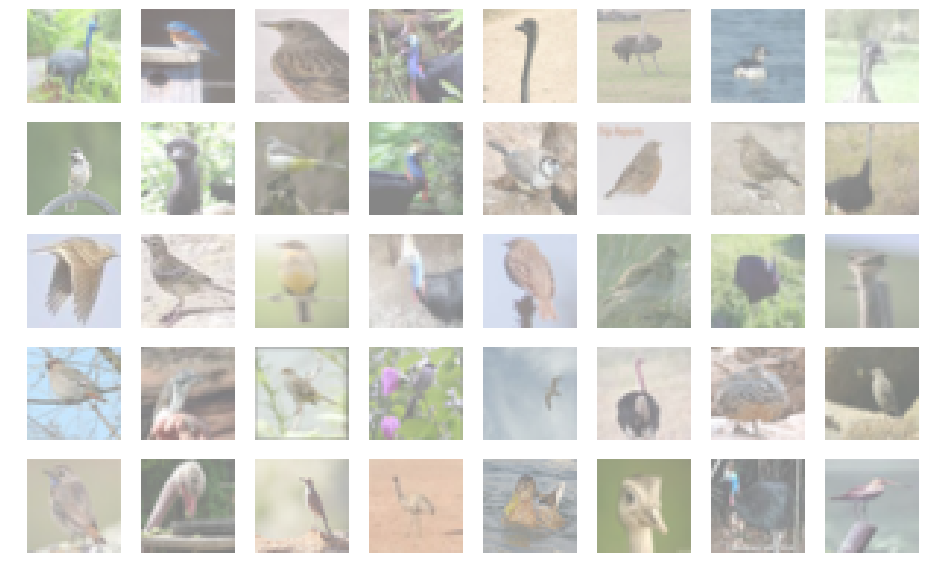

In [14]:
s=X_train[:40]
s = 0.5 * s + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(s):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

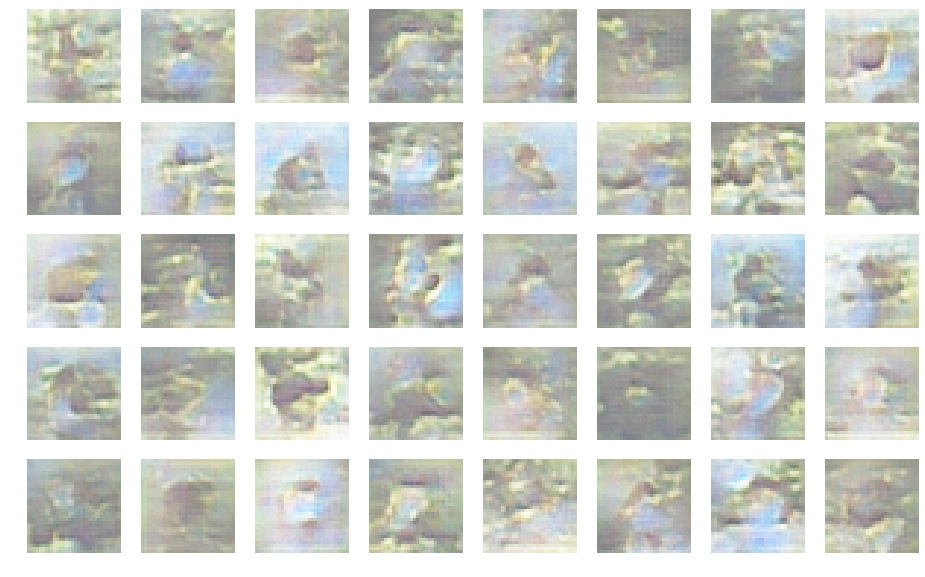

In [15]:
noise = np.random.normal(size=(40, latent_dim))
generated_images = generator.predict(noise)
generated_images = 0.5 * generated_images + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(generated_images):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()